In [1]:
from __future__ import division
from numba import cuda, float32
import numpy
import math
import numpy as np
from numba import cuda
print(cuda.gpus)
              

<Managed Device 0>


# Voronoi with jumping flood

Jumping flood is an efficient pattern of communication that exploits parallel computing

![alt text](https://csdl-images.computer.org/trans/tg/2011/03/figures/ttg20110303452.gif)



In [2]:
Seeds_Position = [(50,50), (100,250), (300,200), (169,169), (10,40)]

Seed_number = len(Seeds_Position)
A = np.zeros((320,320)) -1
for i in range(len(Seeds_Position)):
    A[Seeds_Position[i]] = i

offsets = [ (-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1),(0,0) ]
offsets_number = len(offsets)

@cuda.jit
def Voronoi(A, B, Seeds_Position, offsets, k):
    cellx, celly = cuda.grid(2)
    
    soffsets= cuda.shared.array(shape=(offsets_number, 2), dtype=float32)
    sSeeds_Position = cuda.shared.array(shape=(Seed_number, 2), dtype=float32)
    
    # first thread of each block copies Seeds_Position and offsets to shared memory
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    if tx == 0 and ty == 0:
        cuda.syncthreads()
        for i in range(offsets_number):
            soffsets[i,0] = offsets[i,0]
            soffsets[i,1] = offsets[i,1]
        for i in range(Seed_number):
            sSeeds_Position[i,0] = Seeds_Position[i,0]
            sSeeds_Position[i,1] = Seeds_Position[i,1]
        cuda.syncthreads()
        
    seed = A[cellx,celly]
    if (seed < 0):
        return
    
    for i in range(len(offsets)):
        nextCellx = int(cellx + k*soffsets[i][0])
        nextCelly = int(celly + k*soffsets[i][1])
        
        if nextCellx>0 and nextCellx<A.shape[0] and nextCelly>0 and nextCelly<A.shape[1]:
            
            # Critical Session
            cuda.syncthreads()

            nextSeed = B[nextCellx,nextCelly]
            if nextSeed < 0:
                B[nextCellx,nextCelly] = seed
            else:
                # Read shared memory
                seedx,seedy = sSeeds_Position[int(seed)]
                nextSeedx,nextSeedy = sSeeds_Position[int(nextSeed)]
                
                # compute distance from seed and nextSeed
                dist_seed = (nextCellx - seedx)**2 + (nextCelly - seedy)**2
                dist_nextSeed = (nextCellx - nextSeedx)**2 + (nextCelly - nextSeedy)**2
                if dist_seed < dist_nextSeed:
                    B[nextCellx,nextCelly] = seed
                    
            cuda.syncthreads()

In [3]:

n,m = A.shape       
A_global_mem = cuda.to_device(A)
B_global_mem = cuda.to_device(A)
Seeds_Position_global_mem = cuda.to_device(np.array(Seeds_Position,dtype=np.int32))
offsets_global_mem = cuda.to_device(np.array(offsets,dtype=np.int32))


TPB = 32
threadsperblock = (TPB,TPB)
blockspergrid = ((n+TPB-1)//TPB, (m+TPB-1)//TPB)
print(A.shape)
print(blockspergrid)
print(threadsperblock)

q = 2
k = n
while(k>0):
    k = n//(2**q)
    q += 1
    if q%2 == 0:
        src,dst = A_global_mem,B_global_mem
    else:
        src,dst = B_global_mem,A_global_mem
    Voronoi[blockspergrid, threadsperblock](src, dst,
                                            Seeds_Position_global_mem, 
                                            offsets_global_mem,
                                            k)

res = dst.copy_to_host()

(320, 320)
(10, 10)
(32, 32)


Populating the interactive namespace from numpy and matplotlib


/home/mario/anaconda3/envs/computer_vision/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['float32']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


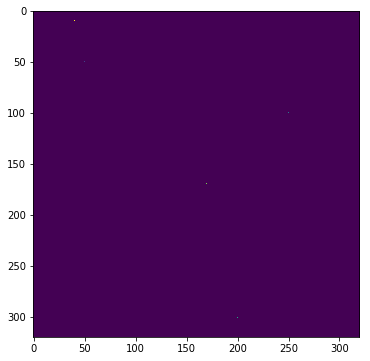

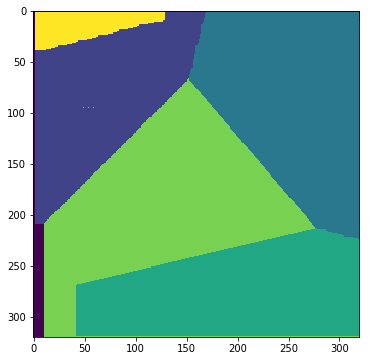

In [4]:
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 6)

plt.imshow(A)
plt.show()

plt.imshow(res)
plt.show()